# **SIEFORE Básica Inicial: Optimización del Portafolio**

Este jupyter notebook incluye la optimización de Markowitz para el portafolio de inversión de Marxianos Siefore Básica Inicial S.A. de C.V.

> **Nota**: Sociedad Anónima y SIEFORE de fantasia.

## Modificaciones sobre Markowitz() original
- `self.portafolio_frontera_eficiente`:
    - con restricciones para CONSAR
    - Temporalidad actualizada en columnas y ejes (muestra si es Anual o temporalidad base)
    - DataFrame ahora regresa rendimiento, volatilidad, ponderaciones y sharpe
    - Cálculo del portafolio tangente (Máximo Sharpe) mediante máximo global de la tasa de crecimiento del Sharpe.
    - Cambio sobre visualización, colores en titulo, ejes y color map
## Por hacer
- Actualizar el rendimiento libre de riesgo con pronostico de este año
- Probar 5% para ETFs indexados
- Calcular VaR
- Desempeño Bechmark vs Portafolio


## Desarrollo

In [23]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import datetime
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import regex as re
import refinitiv.data as rd
from scipy.stats import linregress, norm
from scipy.optimize import minimize
import openpyxl
import xlsxwriter

In [2]:
class Markowitz():
    """
    Es una clase que genera un análisis de Markowitz con series de tiempo de valores financieros.

    Argumentos
    indices: list-like
        Indica si existen índices como marco de referencia para efectuar un análisis básico de sensibilidad
        y calcular las betas de los valores respecto a esta lista.

    datos: dataframe-like
        Es un conjunto de series de tiempo para valores financieros.
        Se espera un dataframe con los valores como columnas y fechas como filas.

    temporalidad: str
        Indica la temporalidad de los datos de la serie del tiempo.
        d: Diaria
        m: Mensual
        y: Anual

    vlr_dict: dict
        Diccionario con el nombre del instrumento de valor libre de riesgo como clave,
        y su rendimiento porcentual anual como valor númerico (e.g. 10% = 0.1, 0.1 es aceptado).
        
    metodo_optimizacion: str
        Es el metodo utilizado para la optimización de funciones

    """
    def __init__(self, datos, temporalidad="m", indices=None, vlr_dict={'vlr':0}, metodo_optimizacion='SLSQP'):
        # Se parte del supuesto que para series de tiempo, la columna 0 esta asociada a los fechas
        # Se pone como índice las fechas
        self.datos = datos.copy().set_index(datos.columns[0])
        self.fechas = self.datos[self.datos.columns[0]]
        self.vlr_dict = vlr_dict
        self.vlr_nombre = list(self.vlr_dict.keys())[0]
        self.vlr_rendimiento = list(self.vlr_dict.values())[0]
        self.temporalidad = temporalidad
        # Diccionario de los números equivalentes para anualizar los resultados.
        self.temporalidad_dict = {
            'd': 252, # Comprobar
            'm': 12
            }
        # Asigna el factor de temporalidad en función de su temporalidad
        self.factor_temporalidad = self.temporalidad_dict[self.temporalidad]

        # Verifica si existen indices
        if indices:
            # Genera un conjunto solo con los valores
            self.indices_nombres = indices
            self.indices_series = self.datos[indices]
            self.indices_num = len(indices)
            # Genera un conjunto con solo los valores que no esten en los indices
            self.valores_nombres = [valor for valor in self.datos.columns if valor not in indices]
            self.valores_series = self.datos[self.valores_nombres]
        else:
            self.indices_nombres = indices
            self.indices_series = indices
            self.indices_num = 0
            # Genera un conjunto con todas las columnas, exceptuando la fecha
            self.valores_nombres = self.datos.columns
            self.valores_series = self.datos[self.valores_nombres]
        # Número de valores
        self.valores_num = len(self.valores_nombres)
        self.estadisticas_dict = {
            # Genera un vector con los rendimientos esperados de los valores. Supone
            # un rendimiento esperado con el promedio.
            'Rendimiento Esperado': self.valores_series.mean(),
            # Genera un vector con la varianza muestral de los valores.
            'Varianza': self.valores_series.var(),
            # Genera un vector con la desviación estandar de los valores.
            'Desv. Std.': self.valores_series.std(),
            }
        
        # Matriz de covarianza (SE MULTIPLICA POR LA TEMPORALIDAD)?
        self.sigma = self.valores_series.cov()
        # Ponderaciones iniciales del portafolio
        # Hace un vector con ponderaciones equitativemente distribuidas para n valores_num
        self.ponderaciones_iniciales = np.ones(len(self.valores_nombres)) / self.valores_num
        # Parametros para la optimización
        self.metodo_optimizacion = metodo_optimizacion
        # Son los limites que pueden tener las ponderaciones, todos estan dentro del rango 0,1
        self.valores_bounds = [(0,1)] * self.valores_num
        # Las restricciones base para la optimización del portafolio, las ponderaciones
        # deben de sumar uno.
        self.restricciones_base = [
            {'type':'eq', 'fun':self.restricciones_ponderaciones_sumanuno}
            ]
        
        # Parametros gráficas
        self.grafica_size = (10,5)
        # Color de mapa
        self.cmap = "Blues"
        self.titulo_size = 18
        self.titulo_x=0.075
        self.titulo_y=0.95
        self.subtitulo_size = 14
        self.marker_size = 5
        # El tamaño del marker size del portafolio más conservador
        self.pmc_marker_size = 10
        self.pmc_label = "Portafolio más conservador"
        # Color del portafolio más conservador
        self.pmc_color = '#FF2E63'
        # El marcador del pmc es una estrella
        self.pmc_marker = '*'

        self.pid_label = "Portafolio igualmente distribuido"
        # Color del portafolio igualemente distribuido
        self.pid_color = '#252A34'
        # El marcador del pid es un triangulo arriba
        self.pid_marker = '^'

        self.pt_label = "Portafolio tangente"
        self.pt_marker = '$T$'
        self.pt_color = '#06a77d'

        self.titulo_loc = "left"
        self.titulo_color = "#4ba173"

        self.subtitulo_color = "#63d297"
        self.cuerpo_color = "#616161"

        # El cmap para portafolios aleatorios
        self.portal_cmap = "Greens"
        
        # Parametros sobre resumenes
        self.dataframes_generados = {}

        # Limites
        self.limite_indx_econ = 0.05
        self.limite_indx_sec = 0.05

    # Estadisticas 
    def valores_estadisticas(self, dataframe=True, anualizar=False):
        """
        Cálcula estadísticas necesarias para el desarrollo de Markowitz.

        Argumentos:
        datos (pandas dataframe): Es un dataframe con las series de tiempo de los valores.
            NOTA: Las series deben pertenecer a un mismo rango temporal.
        """
        estadisticas_dict = {
            # Genera un vector con los rendimientos esperados de los valores. Supone
            # un rendimiento esperado con el promedio.
            'Rendimiento Esperado': self.valores_series.mean(),
            # Genera un vector con la varianza muestral de los valores.
            'Varianza': self.valores_series.var(),
            # Genera un vector con la desviación estandar de los valores.
            'Desv. Std.': self.valores_series.std(),
            }

        # Verifica si se quiere anualizar las estadisticas y llama la funcion para anualizar
        if anualizar:
            estadisticas_dict = self.valores_estadisticas_anualizar(estadisticas_dict)

        if dataframe:
            return pd.DataFrame(estadisticas_dict)
        else:
            return estadisticas_dict
    

    def valores_estadisticas_anualizar(self, estadisticas_dict):
        """
        Calcula las estadisticas anualizadas de los valores según su temporalidad inicial.

        Regresa un diccionario.
        
        Argumentos
        estadisticas: dict-like
            Es un diccionario con la estadistica como clave y su cálculo como su valor númerico.
        """

        estadisticas_dict_anual = {
            # Genera un vector con los rendimientos esperado anuales de los valores.
            'Rendimiento Esperado Anual': (estadisticas_dict['Rendimiento Esperado'] + 1) ** (self.factor_temporalidad) - 1,
            # Genera un vector con la desviación estandar anual
            'Desv. Std. Anual': estadisticas_dict['Desv. Std.'] * np.sqrt(self.factor_temporalidad),
            }
        # Calcula el Indice de Sharpe: (Rendimiento del Valor - Rendimiento de Valor Libre de Riesgo) / Desv. Std. del Valor
        estadisticas_dict_anual["Indice Sharpe"] = self.sharpe_calcular(
            estadisticas_dict_anual["Rendimiento Esperado Anual"],
            self.vlr_rendimiento,
            estadisticas_dict_anual["Desv. Std. Anual"]
            )

        return estadisticas_dict_anual


    def valores_betas(self, dataframe=True):
        """
        Calcula las betas (sensibilidad) de los valores respecto al índice.
        """
        if self.indices_nombres:
            betas = {
                # Calcula la beta (pendiente) de las series de los valores respecto a las de los índices.
                indice: np.array([linregress(datos[indice], datos[valor]).slope for valor in self.valores_nombres])
                for indice in self.indices_nombres
                }
            
            # Revisa si se quiere la opcion con dataframe
            if dataframe:
                # Regresa un dataframe con los resultados
                return pd.DataFrame(betas, index=self.valores_nombres)
            else:
                # Solo regresa el diccionario
                return betas
        else:
            print("No es posible calcular las betas sin al menos un índice de referencia.")
            return None

    def ponderaciones_mas_conservador(self, metodo_optimizacion=None, anualizar=True):
        """
        Calcula las ponderaciones del portafolio más conservador. Es decir,
        aquel portafolio dónde se minimiza la volatilidad con restricción solo
        en que las ponderaciones deben sumar uno.

        Regresa
            array-like: ponderaciones optimizadas

        Argumentos
        metodo_optimizacion: str
            Es el nombre del método de optimización para np.scipy.minimize
        anualizar: boolean
            Indica si se quiere anualizar la volatilidad del portafolio.
        """
        # Verifica si hay metodo de optimizacion
        if metodo_optimizacion:
            metodo_optimizacion = metodo_optimizacion
        else:
            metodo_optimizacion = self.metodo_optimizacion
        # Minimiza la volatilidad y obten las ponderaciones    
        pma = minimize(
            lambda ponderaciones: self.portafolio_volatilidad(ponderaciones, anualizar=anualizar),
            self.ponderaciones_iniciales,
            method=metodo_optimizacion,
            bounds=self.valores_bounds,
            constraints=self.restricciones_base
            )
        # Guarda las ponderaciones de la función de optimizacion
        ponderaciones = pma.x
        # Regresa las ponderaciones
        return ponderaciones

    
    def ponderaciones_tangente(self, anualizar=True):
        """
        Calcula las ponderaciones del portafolio tangente mediante una maximización de
        Sharpe de un portafolio, y una minimización del Índice de Sharpe que calcula las ponderaciones
        positivas asignadas a las acciones del portafolio.

        REGRESA
        ponderaciones_tangente: array-like
            Un array con las ponderaciones optimizadas.
        anualizar: bool-like
            Indica si se quieren anualizar los resultados

        """
        # Maximiza el Sharpe para obtener el portafolio tangente, el modelo implica resultados negativos.
        # (modelo negativo)
        msharpe_modelneg = minimize(
            # La función es (-) porque asi se establece una maximización
            lambda ponderaciones: self.portafolio_sharpe(ponderaciones=ponderaciones, anualizar=anualizar),
            self.ponderaciones_iniciales,
            method=self.metodo_optimizacion,
            bounds=self.valores_bounds,
            constraints=(
                {"type":"eq", "fun": self.restricciones_ponderaciones_sumanuno},
            )
        )
        # Es el valor absoluto del máximo índice de Sharpe
        msharpe = abs(msharpe_modelneg["fun"])
        # Calcula el modelo que minimiza el Índice de Sharpe restringido a que sea el mismo valor
        # msharpe y en terminos positivos. (modelo positivo)
        msharpe_modelpos = minimize(
            lambda ponderaciones: self.portafolio_sharpe(ponderaciones, anualizar=anualizar),
            self.ponderaciones_iniciales,
            method = self.metodo_optimizacion,
            bounds = self.valores_bounds,
            constraints = (
                {"type":"eq", "fun": self.restricciones_ponderaciones_sumanuno},
                {"type":"eq", "fun": lambda ponderaciones: self.portafolio_sharpe(ponderaciones, anualizar=anualizar) - msharpe}
            )

        )
        # Guarda el array de ponderaciones optimizadas
        ponderaciones_tangente = msharpe_modelpos.x
        # Regresa el array de ponderaciones optimizadas
        return ponderaciones_tangente
        

    def portafolio_beta(self, ponderaciones=[]):
        """
        Calcula la beta del portafolio según los valores, sus ponderaciones y sus betas.

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        """

        # Verifica si existen betas en el portafolio
        if self.indices_nombres:
            # Calcula las betas individuales del portafolio
            betas = self.valores_betas()

            # Si hay ponderaciones input, utilizalas
            if len(ponderaciones) > 0:
                beta = np.sum((betas.T * ponderaciones).sum())
            else:
            # Si no hay ponderaciones input, usa las ponderaciones iniciales
                beta = np.sum((betas.T * self.ponderaciones_iniciales).sum())
            return beta
        else:
            print("No es posible calcular las betas sin al menos un índice de referencia.")
            return None


    def portafolio_rendimiento(self, ponderaciones=[], anualizar=True):
        """
        Calcula el rendimiento del portafolio en función de sus valores, ponderaciones y rendimientos esperados.

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        anualizar: bool-like
            Indica si se quiere anualizar los resultados (anualizado por predeterminado)
        """
        if len(ponderaciones) > 0:
            # Si hay input sobre ponderaciones, estos se multiplican por el rendimiento esperado
            # ... y se suman
            if anualizar:
                rendimiento = self.portafolio_rendimiento_anual(ponderaciones=ponderaciones)
            else:
                rendimiento = np.sum(self.estadisticas_dict["Rendimiento Esperado"] * ponderaciones)
        else:
            # Si no hay input sobre ponderaciones, estos se multiplican por las ponderaciones inciciales
            # ... y se suman
            if anualizar:
                rendimiento = self.portafolio_rendimiento_anual(ponderaciones=self.ponderaciones_iniciales)
            else:
                rendimiento = np.sum(self.estadisticas_dict["Rendimiento Esperado"] * self.ponderaciones_iniciales)

        return rendimiento


    def portafolio_rendimiento_anual(self, ponderaciones=[]):
        """
        Calcula el rendimiento anual del portafolio.

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        """
        # Calcula el Rendimiento Esperado Anual de los valores
        valores_rendesp = self.valores_estadisticas(anualizar=True)["Rendimiento Esperado Anual"]
        
        # Rendimiento anual del portafolio
        portafolio_ra = np.sum(valores_rendesp * ponderaciones)
    
        # Regresa el rendimiento anual del portafolio
        return portafolio_ra
            

    def portafolio_varianza(self, ponderaciones=[]):
        """
        Calcula la varianza del portafolio en función de los valores, sus ponderaciones y sigma (matriz covarianza).

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        """
        # Verifica si hay ponderaciones input
        if len(ponderaciones) > 0:
            # Calcula la varianza con las ponderaciones input.
            varianza = np.dot(ponderaciones.T, np.dot(self.sigma, ponderaciones))
            
        else:
            # Calcula la varianza del portafolio al multiplicar las ponderaciones iniciales transpuestas, por el producto matriz
            # de sigma por las ponderaciones iniciales.
            varianza = np.dot(self.ponderaciones_iniciales.T, np.dot(self.sigma, self.ponderaciones_iniciales))
        

        return varianza

    
    def portafolio_volatilidad(self, ponderaciones=[], anualizar=False):
        """
        Calcula la volatilidad del portafolio (raíz cuadrada de la varianza del portafolio).

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        anualizar: boolean
            Indica si se quiere anualizar la volatilidad del portafolio.
        """
        factor_temporalidad = self.temporalidad_dict[self.temporalidad]
        # Verifica si hay ponderaciones input
        if len(ponderaciones) > 0:
            varianza = self.portafolio_varianza(ponderaciones=ponderaciones)
        else:
            varianza = self.portafolio_varianza(ponderaciones=self.ponderaciones_iniciales)
        # Calcula la volatilidad con la raiz de la varianza del portafolio
        volatilidad = np.sqrt(varianza)

        if anualizar:
            # CONFIRMAR QUE HAY QUE MULTILICAR POR LA RAIZ DEL FACTOR DE TEMPORALID
            # Si hay que anualizar, se anualiza la volatilidad según su factor de temporalidad
            volatilidad = volatilidad * np.sqrt(self.factor_temporalidad)

        return volatilidad

    
    def portafolio_sharpe(self, ponderaciones=[], rendimiento_anual=None, anualizar=True):
        """
        Calcula el índice de Sharpe del portafolio en función de sus valores, rendimientos,
        desviación estándar y la desviación estándar del portafolio.

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        rendimiento_anual: numeric-like
            Es el rendimiento anual del portafolio.
        anualizar: bool-like
            Indica se se quiere anualizar los resultados del Sharpe (se aplica sobre la volatilidad)
        """
        if len(ponderaciones) > 0:
            # Si hay ponderaciones input, usalas en las funciones para calcular el
            # ... rendimiento y volatilidad del portafolio
            psharpe = self.sharpe_calcular(
                self.portafolio_rendimiento(ponderaciones=ponderaciones, anualizar=anualizar),
                self.vlr_rendimiento,
                self.portafolio_volatilidad(ponderaciones=ponderaciones, anualizar=anualizar)
                )
        else:
            # Si no hay ponderaciones, se calcula con las ponderaciones iniciales
            psharpe = self.sharpe_calcular(
                self.portafolio_rendimiento(anualizar=anualizar),
                self.vlr_rendimiento,
                self.portafolio_volatilidad(anualizar=anualizar)
                )

        return psharpe

    
    def portafolio_var(self, ponderaciones=[], probabilidad=0.95):
        """
        Calcula el Value at Risk (VaR) ó Valor en Riesgo, básico del portafolio.

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        probabilidad: float-like (0, 1)
            Es la probabilidad para calcular el VaR del portafolio
        """
        # Verifica si hay ponderaciones input
        if len(ponderaciones) > 0:
            # Rendimiento esperado del portafolio
            p_rendesp = self.portafolio_rendimiento_anual(ponderaciones=ponderaciones)
            # Volatilidad
            p_volatilidad = self.portafolio_volatilidad(ponderaciones=ponderaciones, anualizar=True)
        else:
            p_rendesp = self.portafolio_rendimiento_anual()
            p_volatilidad = self.portafolio_volatilidad(anualizar=True)
        # Calcula el valor de z en tablas de la probabilidad
        zscore = norm.ppf(probabilidad)
        # Calcula el var
        var = (
            # Calcula primero el rendimiento diario
            (p_rendesp/self.temporalidad_dict['d']) +
            (zscore * (p_volatilidad/self.temporalidad_dict['m']))
            )

        return var


    def portafolio_var_rendimiento_anual(
        self, ponderaciones=[], v_num=15, probabilidad=0.95, metodo_optimizacion=None,
        rendimiento_anual_max=0.5):
        """
        Calcula el rendimiento de un rango de VaR. Este rango se compone por la minimización
        del VaR dados ciertos rendimientos. El rango comienza con el rendimiento del VaR minimizado
        con restriccion de ponderaciones suman uno.

        El rango es equitativemente distribuido, es decir, la diferencia es una constante entre los valores númericos.

        Regresa 
        Array de Rendimientos y VaR

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        v_num: int
            Es el número de VaR implicados para calcular su rendimiento anual
        probabilidad: float-like (0, 1)
            Es la probabilidad para calcular el VaR del portafolio
        metodo_optimizacion: str
            Es el nombre del método de optimización para np.scipy.minimize
        rendimiento_anual_max: float_like
            Es el rendimiento anual máximo que se quiere usar como restricción para calcular el VaR
        """
        # Verifica si hay metodo de optimización
        if metodo_optimizacion:
            # Usa el input, si es que hay
            metodo_optimizacion = metodo_optimizacion
        else:
            # De otra manera, usa el metodo predeterminado
            metodo_optimizacion = self.metodo_optimizacion

        Var = []
        # Calcula el VaR mínimo mediante la minimzación de la función de portafolio_var
        rango_var_inferior = minimize(
            lambda ponderaciones: self.portafolio_var(ponderaciones, probabilidad=probabilidad),
            self.ponderaciones_iniciales,
            method=metodo_optimizacion,
            bounds=self.valores_bounds,
            constraints=self.restricciones_base)

        # Cálcula el límite inferior de los rangos
        rango_rend_inferior = self.portafolio_rendimiento_anual(rango_var_inferior.x)
        rango_rend_superior = rendimiento_anual_max
        # Genera el vector con espacios 
        Rendimientos = np.linspace(rango_rend_inferior, rango_rend_superior, v_num)
        for rendimiento in Rendimientos:
            # Minimiza el VaR dado un rendimiento
            var = minimize(
                # Máximiza el rendimiento 
                lambda ponderaciones: self.portafolio_var(ponderaciones, probabilidad=probabilidad),
                self.ponderaciones_iniciales,
                method=metodo_optimizacion,
                bounds=self.valores_bounds,
                constraints=self.restricciones_base +
                    [{'type':'eq', 'fun':lambda ponderaciones: self.portafolio_rendimiento_anual(ponderaciones) - rendimiento}]
                )
            # Verifica si se pudo optimizar
            if var.success == True:
                # Agrega los rendimientos anuales al pasar las ponderaciones calculadas
                Var.append(var.fun)
            else:
                break
                print("Se rompio")

        return np.array(Var), Rendimientos

    def portafolio_var_rendimiento_anual_resumen(self, ponderaciones=[], probabilidad=0.95, rendimiento_anual_max=0.5):
        """
        Gráfica los resultados de portafolio_var_rendimiento_anual y
        regresa su dataframe.

        Regresa
        Grafica (plt)

        Argumentos
        ponderaciones: array-like
            Es un vector con las ponderaciones de los valores en el portafolio
        probabilidad: float-like (0, 1)
            Es la probabilidad para calcular el VaR del portafolio
        """
        # Llama los resultados del Var y Rendimientos data una probabilidad
        Var, Rendimientos = self.portafolio_var_rendimiento_anual(ponderaciones, probabilidad=probabilidad,
        rendimiento_anual_max=rendimiento_anual_max)
        # Calcula el Rendimiento Anual y VaR con las ponderaciones del portafolio más conservador
        pmc = self.ponderaciones_mas_conservador()
        # Var más conservador
        var_pmc = self.portafolio_var(pmc, probabilidad=probabilidad)
        # Calcula el rendimiento anual
        rendan_pmc = self.portafolio_rendimiento_anual(pmc)

        # Calcula el Rendimiento Anual y Var con ponderaciones igualmente distribuidas
        var_pid = self.portafolio_var(self.ponderaciones_iniciales, probabilidad=probabilidad)
        rendan_pid = self.portafolio_rendimiento_anual(self.ponderaciones_iniciales)

        # Calcula el Rendimiento Anual y VaR del portafolio tangente
        # Ponderaciones del portafolio tangente
        pt_pond = self.ponderaciones_tangente()
        var_pt = self.portafolio_var(pt_pond, probabilidad=probabilidad)
        rendan_pt = self.portafolio_rendimiento_anual(pt_pond)
        
        # Titulo de la grafica
        titulo = "Valor en Riesgo (VaR) vs. Rendimiento Anual"
        # String del subtitulo de la grafica
        subtitulo = "Del portafolio con {tres_valores} & {num_restantes} valores financieros más".format(
            tres_valores=', '.join(self.valores_nombres[:3]),
            num_restantes=self.valores_num-3)

        # Portafolio Var Rendimiento Anual Grafica
        plt.figure(figsize=(10,5))
        # Grafica los Valores en Riesgo (VaR) contr Rendimientos
        plt.plot(Var, Rendimientos, "o-", markersize=self.marker_size, alpha=0.5)
        # Gráfica los Valores del portafolio más conservador
        plt.scatter(var_pmc, rendan_pmc, c=self.pmc_color, marker=self.pmc_marker, label="Portafolio más conservador")
        # Gráfica los Valores del portafolio igualmente distribuido
        plt.scatter(var_pid, rendan_pid, c=self.pid_color, marker=self.pid_marker, label="Portafolio igualmente distribuido")
        # Gráfica los valores del portafolio tangente
        plt.scatter(var_pt, rendan_pt, c=self.pt_color, marker=self.pt_marker, label="Portafolio tangente")
        # Nombra al eje x en función de la probabilidad del VaR
        plt.xlabel("Valor en Riesgo @{:.2f}%".format(probabilidad*100))
        # Nombre al eje y
        plt.ylabel("Rendimiento Anual")
        # Genera el titulo superior
        plt.suptitle(
            titulo,
            fontweight="bold",
            size=self.titulo_size,
            x=self.titulo_x,
            y=self.titulo_y,
            ha=self.titulo_loc)
        # Genera el subtitulo
        plt.title(
            subtitulo,
            size=self.subtitulo_size,
            loc=self.titulo_loc)
        # Agrega leyendas
        plt.legend()
        # Haz que la gráfica se ajuste para que los elementos esten cercanos
        plt.tight_layout()

        # Genera una lista con las tuplas de VaR, rendimiento para cada uno de
        # los valores de VaR
        resultados_tuples = [(v, r) for v, r in zip(Var, Rendimientos)]
        # Columnas del dataframe
        resultados_index = ["pmc", "pid", "pt"] + ["optimizado{}".format(i) for i in range(len(resultados_tuples))]
        resultados_tuples = [(var_pmc, rendan_pmc)] + [(var_pid, rendan_pid)] + [(var_pt, rendan_pt)] + resultados_tuples

        # Regresa la gráfica
        dataframe = pd.DataFrame(resultados_tuples, columns=["VaR", "Rendimiento Anual"], index=resultados_index)
        # Actualiza la lista de dataframes generados para guardar
        self.dataframes_generados[
            # LLama al dataframe como (var)(ren)dimiento(an)ual_(p)robabilidad
            # Se reemplaza los 0s y puntos de la probabilidad para que pueda
            # guardarse el nombre
            "Varrendan_p{}".format(re.sub('[0\.]', '', str(probabilidad)))
            ] = dataframe
        # Regresa la grafica y el dataframe con resultados
        return plt, dataframe

    def portafolios_aleatorios(self, p_num=1000, rendimiento_libre_riesgo=None, dataframe=True, anualizar=True):
        """
        Genera p_num número de portafolios con pesos aleatorios.

        Parametros
        p_num (int): Número de portafolios por generar.
        val_num (int): Número de valores dentro del portafolio.
        dataframe (bool): Indica si se arrojan los resultados en forma de dataframe o no.
        rendimiento_libre_riesgo (float): Indica el valor de rendimiento sin riesgo.
        anualizar: bool-like
            Indica si se quieren anualizar los resultados
        """
        rendimiento_libre_riesgo = self.verifica_rendimiento_libre_riesgo(rendimiento_libre_riesgo)
        # Define los valores de rendimiento esperado
        if anualizar:
            valores_rendesp = self.valores_estadisticas(anualizar=anualizar)["Rendimiento Esperado Anual"]
        else:
            valores_rendesp = self.valores_estadisticas(anualizar=anualizar)["Rendimiento Esperado"]

        # Genera una matriz de 0s con p_num "filas" * val_num "columnas".
        Ponderaciones = np.zeros(shape=(p_num, self.valores_num))
        # Genera una matriz de 0s con una "fila" para insertar los Rendimientos Esperados
        # ... de portafolios aleatorios
        Rendesp = np.zeros(shape=(p_num))
        # Genera una matriz de 0s con una "fila" para insertar la Volatilidad Esperada
        # ... de portafolios aleatorios
        Volesp = np.zeros(shape=(p_num))
        # Genera una matriz de 0s con una "fila" para insertar las Proporciones de Sharpe
        # ... de portafolios aleatorios
        Sharpeesp = np.zeros(shape=(p_num))

        for k in range(p_num):
            # Genera una matriz de 1 "fila" * val_num "columnas".
            ponderaciones_aleatorias = np.array(np.random.random(self.valores_num))
            # Estandariza los pesos para que su suma equivalga a 1
            ponderaciones_aleatorias = ponderaciones_aleatorias / np.sum(ponderaciones_aleatorias)
            # Actualiza la matriz de Pesos con los ponderaciones_aleatorias
            Ponderaciones[k, :] = ponderaciones_aleatorias

            # Calcula el Rendimiento Esperado del portafolio aleatorio
            Rendesp[k] = np.sum(valores_rendesp * ponderaciones_aleatorias)
            # Calcula la Volatilidad Esperada del portafolio aleatorio
            Volesp[k] = self.portafolio_volatilidad(ponderaciones=ponderaciones_aleatorias, anualizar=anualizar)
            # Calcula la Proporción de Sharpe del portafolio aleatorio
            Sharpeesp[k] = self.sharpe_calcular(Rendesp[k], rendimiento_libre_riesgo, Volesp[k])

        return Ponderaciones, Rendesp, Volesp, Sharpeesp

    
    def portafolio_frontera_eficiente(self, rendinf=0, rendsup=0.5, num_estimaciones=25, metodo_optimizacion=None, anualizar=True, restricciones_frontef=None):
        """
        Calcula la Frontera Eficiente del Portafolio de Markowitz

        Parámetros
        rendif (float): Es el límite inferior para el rango de rendimientos por calcular.
        rendsup (float): Es el límite superior para el rango de rendimientos por calcular.
        num_estimaciones (int): Es el número de puntos/estimaciones para definir la frontera óptima.
        metodo_optimizacion (str): Es el método de minimización para el cálculo de la frontera óptima.
        anualizar: bool-like
            Indica si se quieren los resultados anualizados
        """

        # Genera una matriz de Rendimientos por calcular con un rendimiento inferior y superior
        # con un num_estimaciones dado. Los rendimientos estan uniformemente espaciados.
        Rendimientos = np.linspace(rendinf, rendsup, num_estimaciones)
        # Lista para llenar con Volatilidades Óptimas
        VolatilidadesOpt = []
        # Lista para llenar con ponderaciones Óptimas
        PonderacionesOpt = []
        # Lista para llenar con Sharpe Óptimas
        SharpeOpt = []
        metodo_optimizacion = self.verifica_metodo_optimizacion(metodo_optimizacion)
        # Verifica si existe un nuevo metodo de restricciones

        for rendimiento in Rendimientos:
            # Son las restricciones para optimizar los valores de la frontera óptima dado un rendimiento
            restricciones_frontopt = [
                # Restrición de Renta Variable
                {'type':'eq', 'fun': lambda ponderaciones: self.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_renta_variable, 0.6)},
                # Restricción internacional
                {'type':'eq', 'fun': lambda ponderaciones: self.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_internacional, 0.2)},
                # Restricción de FIBRA
                {'type':'eq', 'fun': lambda ponderaciones: self.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_fibras, 0.1)},
                # Restricción de economia indexada
                {'type':'eq', 'fun': lambda ponderaciones: self.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_indexado_economia, self.limite_indx_econ)},
                # Restricción de sector indexado
                {'type':'eq', 'fun': lambda ponderaciones: self.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_indexado_sector, self.limite_indx_sec)},
                # Restricción de todas las ponderaciones deben sumar 1
                # El rendimiento del portafolio calculado debe de ser al mismo especificado en Rendimientos
                # SUPONE UN RENDIMIENTO EN TEMPORALIDAD BASE
                {'type':'eq', 'fun': lambda ponderaciones: self.portafolio_rendimiento(ponderaciones, anualizar=anualizar) - rendimiento},
                {'type':'eq', 'fun': self.restricciones_ponderaciones_sumanuno}
                ]
            
            
            # Calcula la Volatilidad óptima mediante una función de minimización
            volopt = minimize(
                lambda ponderaciones: self.portafolio_volatilidad(ponderaciones, anualizar=anualizar),
                self.ponderaciones_iniciales,
                method=metodo_optimizacion, 
                bounds=self.valores_bounds, 
                constraints=restricciones_frontopt
                )
            # Inserta la volatilidad óptima del rendimiento dado en la lista de Volatilidades Óptimas
            VolatilidadesOpt.append(volopt['fun'])
            # Agrega las ponderaciones a la lista
            PonderacionesOpt.append(volopt.x)
            # Calcula el sharpe óptimo
            sharpeopt = self.sharpe_calcular(rendimiento, self.vlr_rendimiento, volopt['fun'])
            # Agrega el sharpe optimo a la lista
            SharpeOpt.append(sharpeopt)

            print("[Frontera Eficiente] @ Rendimiento: {:.2f} OPTIMIZADO: [{}]".format(rendimiento, volopt["success"]))


        return Rendimientos, VolatilidadesOpt, PonderacionesOpt, SharpeOpt


    def portafolio_frontera_eficiente_resumen(
        self, rendinf=0, rendsup=0.5, num_estimaciones=25, metodo_optimizacion=None,
        p_num=1000, porciento=False, rendimiento_libre_riesgo=None, dataframe=True, anualizar=True):
        """
        Gráfica la frontera eficiente, portafolios aleatorios y portafolios de interés (igualmente distribuido,
        más conservador y tangente)

        rendif: float
            Es el límite inferior para el rango de rendimientos por calcular.
        rendsup:float 
            Es el límite superior para el rango de rendimientos por calcular.
        num_estimaciones:int
            Es el número de puntos/estimaciones para definir la frontera óptima.
        metodo_optimizacion:str
            Es el método de minimización para el cálculo de la frontera óptima.
        p_num: int
            Número de portafolios por generar.
        porciento: bool
            Indica si se quiere presentar los resultados en forma porcentual
        val_num: int
            Número de valores dentro del portafolio.
        rendimiento_libre_riesgo:float
            Indica el valor de rendimiento sin riesgo.
        dataframe: bool
            Indica si se arrojan los resultados en forma de dataframe o no.
        anualizar: bool-like
            Indica si se quieren los resultados anuales
        """
        # Verifica si hay metodo
        metodo_optimizacion = self.verifica_metodo_optimizacion(metodo_optimizacion)
        rendimiento_libre_riesgo = self.verifica_rendimiento_libre_riesgo(rendimiento_libre_riesgo)

        titulo = "Frontera Eficiente de Markowitz"
        subtitulo = "Del portafolio con {tres_valores} & {num_restantes} valores financieros más".format(
            tres_valores=', '.join(self.valores_nombres[:3]),
            num_restantes=self.valores_num-3)
        
        # Si es anualizado, usa "Anual" para los nombres de columnas de valores eficientes y eje de los graficos,
        # de otra forma usa la temporalidad base
        if anualizar:
            ve_temporalidad = "Anual"
        else:
            ve_temporalidad = self.temporalidad
        
        print("Calculando valores del Portafolio más conservador...")
        # Obtiene las ponderaciones al optimizar en funcion de la volatibilidad y el argumento anualizar
        pmc_pond = self.ponderaciones_mas_conservador(anualizar=anualizar) 
        pmc_rend = self.portafolio_rendimiento(pmc_pond, anualizar=anualizar) 
        pmc_vol = self.portafolio_volatilidad(pmc_pond, anualizar=anualizar) 
        print("Calculado valores del Portafolio igualmente distribuido...")
        pid_pond = self.ponderaciones_iniciales
        pid_rend = self.portafolio_rendimiento(pid_pond, anualizar=anualizar)
        pid_vol = self.portafolio_volatilidad(pid_pond, anualizar=anualizar) 
        # PORTAFOLIO TANGENTE FALLO EN OPTIMIZACION
        # print("Calculando valores del Portafolio tangente...")
        # pt_pond = self.ponderaciones_tangente(anualizar=anualizar)
        # pt_rend = self.portafolio_rendimiento(pt_pond, anualizar=anualizar)
        # pt_vol = self.portafolio_volatilidad(pt_pond, anualizar=anualizar)
        print("Calculando la frontera eficiente...")
        Rend_ef, Vol_ef, Pond_ef, Sharpe_ef = self.portafolio_frontera_eficiente(rendinf=rendinf, rendsup=rendsup, num_estimaciones=num_estimaciones, anualizar=anualizar) 
        print("Calculando portafolios aleatorios...")
        pond, Rend_al, Vol_al, Sharp_al = self.portafolios_aleatorios(p_num=p_num, rendimiento_libre_riesgo=rendimiento_libre_riesgo, anualizar=anualizar) 
        

        plt.figure(figsize=self.grafica_size)
        # Gráfica los resultados de la Frontera Eficiente
        plt.plot(Vol_ef, Rend_ef, c='black', label="Frontera Eficiente Markowitz", alpha=0.5)
        # Gráfica los resultados de Portafolios Aleatorios
        plt.scatter(Vol_al, Rend_al, c=Sharp_al, cmap=self.portal_cmap, label="Portafolios Aleatorios")
        # Gráfica los resultados del portafolio más conservador
        plt.scatter(pmc_vol, pmc_rend, c=self.pmc_color, marker=self.pmc_marker, label=self.pmc_label)
        # Gráfica los resultados del portafolio igualmente distribuido
        plt.scatter(pid_vol, pid_rend, c=self.pid_color, marker=self.pid_marker, label=self.pid_label)
       

        # Valores eficientes
        ve = [(v, r, p, s) for v, r, p, s in zip(Vol_ef, Rend_ef, Pond_ef, Sharpe_ef)]


        ve_index = ["pmc", "pid" ] + ["eficiente{}".format(i) for i in range(len(ve))]
        ve = [(pmc_vol,pmc_rend,pmc_pond,1)] + [(pid_vol, pid_rend, pid_pond, 1)] + ve

        # Columnas de valores eficientes y ejes
        ve_columnas = [
            "Volatilidad {}".format(ve_temporalidad),
            "Rendimiento Esperado {}".format(ve_temporalidad),
            "Ponderaciones",
            "Sharpe"]
        # Crea un dataframe con los resultados eficientes
        dataframe = pd.DataFrame(ve, columns=ve_columnas, index=ve_index)
        # Haz una copia del dataframe para calcular el Sharpe Máximo
        dataframe_msharpe = dataframe.copy()
        dataframe_msharpe["Sharpe %"] = dataframe_msharpe["Sharpe"].pct_change()
        # Define el índice del máximo local del crecimiento del Sharpe. Es el máximo antes de entrar en crecimientoes negativos.
        index_msharpe = dataframe_msharpe[dataframe_msharpe["Sharpe %"] > 0]["Sharpe %"].idxmin()
        # Encuentra la serie del index_Msharpe dentro del dataframe de msharpe
        msharpe_info = dataframe_msharpe.loc[index_msharpe]
        # Extrae el Sharpe del portafolio con mayor sharpe
        msharpe = msharpe_info["Sharpe"]
        # Extrae la Volatilidad del portafolio con mayor sharpe
        pt_vol = msharpe_info["Volatilidad {}".format(ve_temporalidad)]
        # Extrae el Rendimiento del portafolio con mayor sharpe
        pt_rend = msharpe_info["Rendimiento Esperado {}".format(ve_temporalidad)]


         # Grafica el Capital Market Line
                        # Ordenada al origen        # pendiente                
        plt.axline((0, rendimiento_libre_riesgo), slope=msharpe, c="red", linestyle="--",
        label="Capital Market Line (CML)", alpha = 0.5)
        # Grafica el portafolio tangente
        plt.scatter(pt_vol, pt_rend, c= self.pt_color, marker=self.pt_marker, label=self.pt_label)

        # Nombra el eje x
        plt.xlabel("Riesgo {}".format(ve_temporalidad), color=self.titulo_color, weight="bold")
        # Nombra el eje y
        plt.ylabel(ve_columnas[1], color=self.titulo_color, weight="bold")
        # Genera el titulo superior
        plt.suptitle(
            titulo,
            fontweight="bold",
            size=self.titulo_size,
            x=self.titulo_x,
            y=self.titulo_y,
            ha=self.titulo_loc,
            color=self.titulo_color)
        # Genera el subtitulo
        plt.title(
            subtitulo,
            size=self.subtitulo_size,
            loc=self.titulo_loc,
            color=self.cuerpo_color)
        
        # Genera texto para anotaciones (dos espacios despues de linea nueva)
        notas = "Notas:\n  Portafolios aleatorios: {:,}\n  Portafolios eficientes: {:,}\n  Índice de Sharpe máximo: {:.2f}\n  CML = {:.4f} + {:.2f} Riesgo {}".format(
            p_num, num_estimaciones, msharpe, rendimiento_libre_riesgo, msharpe, ve_temporalidad
        )
        plt.figtext(x=self.titulo_x, y=-0.105, s=notas, color=self.cuerpo_color)
        smap = plt.cm.ScalarMappable(cmap=self.portal_cmap)
        plt.colorbar(smap, label="Índice de Sharpe (RLR = {:.2f} %)".format(rendimiento_libre_riesgo*100))
        plt.legend()
        plt.tight_layout()

        return plt, dataframe


    def restricciones_ponderaciones_sumanuno(self, ponderaciones):
        """
        Es una función que verifica que la suma de las ponderaciones sean 1

        Argumentos
        ponderaciones: array-like
        """
        # Suma de ponderaciones = 1;
        # Suma de poneraciones - 1 = 0
        return np.sum(ponderaciones) - 1
        
        
    def restricciones_ponderaciones_i_suman_x(self, ponderaciones, indices, x):
        """
        Verifica que las ponderaciones con cierto indice (númerico) sumen un valor x.

        # Parámetros
        ponderaciones: list-like
            Lista de ponderaciones.
            e.g. [0.5, 0.5]
        indices: list-like
            Lista de índices para ubicar activos específicos según su índice en las ponderaciones.
            e.g. [1, 2, 3]
        x: float-like
            Número de restricción. Limita la suma que las ponderaciones de ciertos activos pueden alcanzar.
            e.g. 0.5
        """
        return np.sum(ponderaciones[indices]) - x

    def sharpe_calcular(self, rendimiento_riesgo, rendimiento_libre, desv_std):
        """
        Calcula el índice de sharpe en funcion del rendimiento de valor de riesgo, rendimiento libre de riesgo
        y la desviación estándar del valor/portafolio. El valor de riesgo tambien puede ser un portafolio

        Argumentos
        rendimiento_riesgo: numeric-like
            Es el rendimiento del valor de riesgo
        rendimiento_libre: numeric-like
            Es el rendimiento del valor libre de riesgo
        desv_std: numeric_like
            Es la desviación estándar del valor de riesgo
        """
        # Si la desviación estándar es igual a 0, es decir, las series de tiempo tienen valor constante
        # se supone Desv. Std. = 1
        
        if type(desv_std) == pd.core.series.Series:
            desv_std = desv_std.replace(0, 1)

        else:
            desv_std = np.float64(desv_std)
            if desv_std == 0:
                desv_std = 1

        sharpe = (rendimiento_riesgo - rendimiento_libre) / desv_std
        return sharpe

    def verifica_metodo_optimizacion(self, metodo_optimizacion):
        """
        Verifica si hay un metodo de optimización y lo regresa dadas las condiciones.

        Argumentos
        metodo_optimizacion: str
            Es el nombre del método de optimización para np.scipy.minimize
        """
        if metodo_optimizacion:
            # Si hay, utiliza el input
            metodo_optimizacion = metodo_optimizacion
        else:
            # Si no hay, utiliza el metodo inicializado con la clase
            metodo_optimizacion = self.metodo_optimizacion

        return metodo_optimizacion


    def verifica_rendimiento_libre_riesgo(self, rendimiento_libre_riesgo):
        """
        Verifica si hay rendimiento libre de riesgo y regresa dadas las condiciones.

        Argumentos
        rendimiento_libre_riesgo: float
            Indica el valor de rendimiento sin riesgo.
        """
        # Verifica si hay input de rendimiento_libre_riesgo
        if rendimiento_libre_riesgo:
            rendimiento_libre_riesgo = rendimiento_libre_riesgo
        # Si no, utiliza el vlr inicializado
        else:
            rendimiento_libre_riesgo = self.vlr_rendimiento

        return rendimiento_libre_riesgo

In [3]:
# Funciones de interes
def rendimiento_diario(rendimiento_anual):
    rendimiento_diario = (rendimiento_anual + 1) ** (1/252) - 1
    return rendimiento_diario


def ponderaciones_i_suman_x(ponderaciones, indices, x):
    """
    Verifica que las ponderaciones con cierto indice (númerico) sumen un valor x.

    # Parámetros
    ponderaciones: list-like
        Lista de ponderaciones.
        e.g. [0.5, 0.5]
    indices: list-like
        Lista de índices para ubicar activos específicos según su índice en las ponderaciones.
        e.g. [1, 2, 3]
    x: float-like
        Número de restricción. Limita la suma que las ponderaciones de ciertos activos pueden alcanzar.
        e.g. 0.5
    """
    return np.sum(ponderaciones[indices]) - x

In [4]:
# Variables de interes
rlr = (7.32/100) # CETES 28 Dias 07/06/2022
inflacion = 7.65 # May 2022
cetes_1y = round(rendimiento_diario(9.29/100), 6)
print("CETES", cetes_1y)
udibonos_3a = round(rendimiento_diario(inflacion+4.32/100), 6)
print("UDIBONOS", udibonos_3a)
bonosm_5a = round(rendimiento_diario(9.08/100), 6)
print("BONOSM", bonosm_5a)
color_titulo = "#4ba173"
color_subtitulo = "#63d297"
color_cuerpo = "#616161"
color_fondo = "#f5fffaff"
# Color map de Marxianos
cmap_marx = matplotlib.colors.LinearSegmentedColormap.from_list("", [color_fondo, color_titulo])
#cmap_marx = matplotlib.cm.get_cmap("Greens")

CETES 0.000353
UDIBONOS 0.008618
BONOSM 0.000345


In [5]:
# Llama el dataframe con los datos de Total Return
portafolio_data = pd.read_csv("datasets/Marxianos_portfolio_220610.csv")
# Quitale la tasa a los instrumentos de deuda
portafolio_data["Udibonos 3Y"] = portafolio_data["Udibonos 3Y"] - udibonos_3a
portafolio_data["BonosM 5Y"] = portafolio_data["BonosM 5Y"] - bonosm_5a
portafolio_data["Cetes 1Y"] = portafolio_data["Cetes 1Y"] - cetes_1y
portafolio_data.describe()

,IVV,MCHI.O,EWJ,EWU,NAFTRACISHRS.MX,XLK,VNQI.O,XLY,GLD,CORPTRCISHRS.MX,...,KOFUBL.MX,WALMEX.MX,AAPL.OQ,MSFT.OQ,DGE.L,RKT.L,MNST.OQ,Udibonos 3Y,BonosM 5Y,Cetes 1Y
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,...,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000
mean,0.000739,0.000253,0.000304,0.000376,0.000337,0.001126,0.000159,0.000660,0.000503,0.000372,...,0.000250,0.000497,0.001740,0.001337,0.000489,0.000258,0.000837,-0.000059,-0.000117,-0.000015
std,0.014220,0.018879,0.011645,0.014713,0.011177,0.017901,0.011667,0.016064,0.009513,0.012480,...,0.014405,0.016793,0.021455,0.019368,0.015849,0.015152,0.018317,0.004614,0.005357,0.001863
min,-0.115743,-0.097666,-0.098047,-0.119900,-0.063089,-0.138140,-0.107803,-0.126686,-0.053694,-0.135135,...,-0.062138,-0.061128,-0.128647,-0.147390,-0.086921,-0.084337,-0.079340,-0.089145,-0.101806,-0.029393
25%,-0.004476,-0.008584,-0.005227,-0.005671,-0.005797,-0.006743,-0.005047,-0.005798,-0.004061,-0.002468,...,-0.007843,-0.010121,-0.008023,-0.007255,-0.006638,-0.007267,-0.007664,-0.000286,-0.000683,0.000102
50%,0.001385,0.000308,0.000623,0.001330,0.000000,0.002078,0.000579,0.001521,0.000927,0.000000,...,0.000000,0.000615,0.001511,0.001322,0.000317,0.000159,0.001427,0.000205,0.000214,0.000203
75%,0.007206,0.010202,0.006307,0.006984,0.006689,0.009997,0.005517,0.008660,0.005685,0.004425,...,0.008353,0.010666,0.012987,0.010965,0.007686,0.007756,0.009111,0.000760,0.001076,0.000387
max,0.094503,0.209374,0.069444,0.115463,0.044242,0.117319,0.084036,0.093796,0.048530,0.104167,...,0.054484,0.068265,0.119808,0.142169,0.098410,0.080943,0.088291,0.021127,0.028708,0.020162


In [6]:
portafolio_data

,Date,IVV,MCHI.O,EWJ,EWU,NAFTRACISHRS.MX,XLK,VNQI.O,XLY,GLD,...,KOFUBL.MX,WALMEX.MX,AAPL.OQ,MSFT.OQ,DGE.L,RKT.L,MNST.OQ,Udibonos 3Y,BonosM 5Y,Cetes 1Y
0,2019-01-02 00:00:00+00:00,0.000437,-0.005511,0.006905,-0.000681,0.016121,0.000645,-0.007060,0.007575,0.000660,...,0.013848,-0.005003,0.001141,-0.004430,-0.012165,0.001663,-0.009346,0.003619,0.000233,0.000387
1,2019-01-03 00:00:00+00:00,-0.024988,-0.025416,-0.005682,-0.006137,-0.004736,-0.050468,0.001537,-0.021652,0.009066,...,0.011010,-0.019509,-0.099607,-0.036788,-0.007606,-0.009630,-0.015587,0.000951,0.006730,0.001460
2,2019-01-04 00:00:00+00:00,0.035163,0.040588,0.033892,0.027787,0.008803,0.044320,0.021873,0.033094,-0.008086,...,0.006796,0.018667,0.042689,0.046509,0.000182,-0.000168,0.037292,0.001786,0.005456,0.000375
3,2019-01-07 00:00:00+00:00,0.006731,0.009610,0.002478,0.000000,0.009434,0.008943,0.005821,0.022612,0.003458,...,0.007563,0.003625,-0.002226,0.001275,-0.007845,-0.006539,-0.001205,0.002562,-0.004573,0.000300
4,2019-01-08 00:00:00+00:00,0.009853,0.007652,0.004753,0.006008,0.017523,0.008380,0.007840,0.011056,-0.002708,...,0.008233,0.013644,0.019063,0.007251,0.005885,0.017722,0.062337,-0.002357,0.001430,0.000225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2022-06-06 00:00:00+00:00,0.003007,0.023695,0.005438,0.005779,-0.011746,0.000071,0.001262,0.010000,-0.004404,...,-0.012672,-0.026970,0.005228,-0.004703,0.022777,0.006796,0.028481,-0.002229,-0.005343,-0.001230
883,2022-06-07 00:00:00+00:00,0.009284,0.018065,0.003140,0.008467,0.001189,0.011929,-0.002732,-0.002459,0.006518,...,0.016155,-0.011116,0.017586,0.013953,-0.013227,-0.004500,-0.005582,-0.000741,0.000244,-0.000495
884,2022-06-08 00:00:00+00:00,-0.010827,0.031793,-0.013043,-0.014093,-0.006727,-0.011294,-0.006953,-0.005903,-0.000925,...,-0.015457,0.012409,-0.005043,-0.007670,-0.015183,-0.010978,-0.006714,-0.000245,-0.002943,0.000053
885,2022-06-09 00:00:00+00:00,-0.023411,-0.039115,-0.007121,-0.020975,-0.009562,-0.026701,-0.021218,-0.018076,-0.003183,...,-0.008881,-0.010815,-0.035956,-0.020783,-0.000417,-0.009468,-0.010417,0.000994,0.002335,0.000795


In [7]:
# Llama el dataframe de informacion
portafolio_info = pd.read_csv("datasets/Marxianos_portfolio_allinfo_220610.csv")
# Series de Deuda
deuda_series = [
    pd.Series(["Udibonos 3Y", "Renta Fija", "Bono", "Soberano", "Udibonos", "Mexico", "TBC", ".SPVSOVG"], index=portafolio_info.columns),
    pd.Series(["BonosM 5Y", "Renta Fija", "Bono", "Soberano", "BonosM", "Mexico", "S&P Mexico Sovereign Bond Index", ".SPVSOVG"],
     index=portafolio_info.columns),
     pd.Series(
        ["Cetes 1Y", "Renta Fija", "Bono", "Soberano", "Certificados de la Tesorería de la Federación",
         "Mexico", "S&P Mexico Sovereign Bond Index", ".SPVSOVG"],
         index=portafolio_info.columns)
]
# Agrega los valores de deuda
portafolio_info = portafolio_info.append(deuda_series, ignore_index=True).rename(columns={"Unnamed: 0": "Instrumento"})
portafolio_info.to_csv("datasets/Marxianos_portfolio_allinfofinal_220610.csv")
portafolio_info

,Instrumento,Tipo,Categoría,Subcategoría,Nombre,País de intercambio,Nombre Benchmark,Benchmark RIC
0,IVV,Renta Variable,ETF,Economía Indexada,iShares Core S&P 500 ETF,United States of America,S&P 500 TR,.SPXTR
1,MCHI.O,Renta Variable,ETF,Economía Indexada,iShares MSCI China ETF,United States of America,MSCI China NR USD,.dMICN00000NUS
2,EWJ,Renta Variable,ETF,Economía Indexada,iShares MSCI Japan ETF,United States of America,MSCI Japan NR USD,.dMIJP00000NUS
3,EWU,Renta Variable,ETF,Economía Indexada,iShares MSCI United Kingdom ETF,United States of America,MSCI United Kingdom NR USD,.dMIGB00000NUS
4,NAFTRACISHRS.MX,Renta Variable,ETF,Economía Indexada,iShares NAFTRAC,Mexico,S&P/BMV IPC,.MXX
5,XLK,Renta Variable,ETF,Sector Indexado,Technology Select Sector SPDR Fund,United States of America,Technology Select Sector TR,.IXTTR
6,VNQI.O,Renta Variable,ETF,Sector Indexado,Vanguard Global ex-US Real Estate Index Fd;ETF,United States of America,S&P Global Ex-U.S. Property TR,.SPBMGUU
7,XLY,Renta Variable,ETF,Sector Indexado,Consumer Discretionary Select Sector SPDR Fund,United States of America,Consumer Discretionary Select Sector TR,.IXYTR
8,GLD,Renta Variable,ETF,Otros,SPDR Gold Shares,United States of America,Engelhard Gold Index,.GLDD
9,CORPTRCISHRS.MX,Renta Variable,ETF,Otros,iShares Mexico Corporate Bond TRAC,Mexico,S&P/BMV CORPOTRAC TR MXN,.SPVCORT


In [13]:
indices_sp_corp = pd.read_excel("datasets/S&P_Corporate.xls", header=6)[:1258].rename(columns={"Fecha":"Date", "S&P/BMV CORPOTRAC": ".SPVCORT"})
indices_sp_sov = pd.read_excel("datasets/S&P_Sovereign.xls", header=6)[:1258].rename(columns={"Fecha":"Date", "S&P Mexico Sovereign Bond Index": ".SPVSOVG"})
indices_sp_res = pd.read_excel("datasets/S&P_RealEstate.xls", header=6)[:1304].rename(columns={"Fecha":"Date", "S&P Global Ex-U.S. Property (USD)":".SPBMGUU"})


indices_sp_corp = indices_sp_corp.astype({"Date":"datetime64"})
indices_sp_corp[".SPVCORT"] = indices_sp_corp[".SPVCORT"].pct_change()

indices_sp_sov = indices_sp_sov.astype({"Date":"datetime64"})
indices_sp_sov[".SPVSOVG"] = indices_sp_sov[".SPVSOVG"].pct_change()

indices_sp_res = indices_sp_res.astype({"Date":"datetime64"})
indices_sp_res[".SPBMGUU"] = indices_sp_res[".SPBMGUU"].pct_change()

indices_sp = pd.merge(indices_sp_corp, indices_sp_sov, on="Date").merge(indices_sp_res, on="Date").dropna()
indices_sp
indices_sp_res

,Date,.SPBMGUU
0,2017-06-13,NaN
1,2017-06-14,0.005863
2,2017-06-15,-0.009453
3,2017-06-16,0.002225
4,2017-06-19,0.000543
...,...,...
1299,2022-06-06,0.000224
1300,2022-06-07,-0.008464
1301,2022-06-08,-0.000622
1302,2022-06-09,-0.012274


In [14]:
indices_data = pd.read_csv("datasets/Marxianos_indices_220610.csv")
indices_data = indices_data.astype({"Date":"datetime64"})

indices_data = indices_data.merge(indices_sp, on="Date")
indices_data

,Date,.SPXTR,.dMICN00000NUS,.dMIJP00000NUS,.dMIGB00000NUS,.MXX,.IXTTR,.IXYTR,.GLDD,.FR,.UR0000,.SXWESGP,.SPVCORT,.SPVSOVG,.SPBMGUU
0,2019-01-02,0.001272,-0.022427,0.003843,-0.009616,0.015150,0.000673,0.007704,0.003116,0.033212,0.023095,-0.000288,0.001518,0.003216,-0.010535
1,2019-01-03,-0.024498,-0.013647,0.016083,-0.005330,-0.005366,-0.050304,-0.021464,0.003114,0.012625,-0.004947,-0.007700,0.001171,0.005529,0.007628
2,2019-01-04,0.034336,0.028375,-0.021053,0.030963,0.009771,0.043954,0.033423,-0.001548,0.004921,0.022219,0.022119,0.002890,0.006054,0.010882
3,2019-01-07,0.007013,0.014269,0.025839,-0.000082,0.008929,0.008619,0.022499,0.003884,-0.000612,0.012697,0.004115,-0.001750,-0.002126,0.012533
4,2019-01-08,0.009717,0.002925,0.002480,0.004224,0.016544,0.009029,0.010900,-0.007738,0.012088,0.012189,0.008903,-0.000722,0.000064,0.004520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,2022-06-06,0.003145,0.030867,-0.001872,0.012759,-0.012400,0.000233,0.009658,-0.003226,-0.011490,-0.008841,0.008027,-0.002749,-0.004881,0.000224
863,2022-06-07,0.009552,0.002462,-0.004692,0.001417,0.001571,0.012052,-0.002284,-0.004854,0.012548,0.007227,-0.001805,0.000482,-0.001635,-0.008464
864,2022-06-08,-0.010757,0.035549,0.001362,-0.002970,-0.006380,-0.011306,-0.005694,0.004878,0.012678,0.004985,-0.007871,-0.001873,-0.000921,-0.000622
865,2022-06-09,-0.023702,-0.010702,-0.003372,-0.015980,-0.010620,-0.026780,-0.018076,-0.002157,0.000874,-0.014022,-0.012275,0.000724,-0.000785,-0.012274


In [15]:
# Indices para restringir los rendimientos
indices_internacional = portafolio_info[portafolio_info["País de intercambio"] != "Mexico"].index.to_list()
indices_fibras = portafolio_info[portafolio_info["Subcategoría"] == "FIBRA"].index.to_list()
indices_renta_variable = portafolio_info[portafolio_info["Tipo"] == "Renta Variable"].index.to_list()
indices_indexado_sector = portafolio_info[portafolio_info["Subcategoría"] == "Sector Indexado"].index.to_list()
indices_indexado_economia = portafolio_info[portafolio_info["Subcategoría"] == "Economía Indexada"].index.to_list()
indices = {
    "Internacional": indices_internacional,
    "FIBRAs": indices_fibras,
    "Renta Variable": indices_renta_variable
}

Calculando valores del Portafolio más conservador...
Calculado valores del Portafolio igualmente distribuido...
Calculando la frontera eficiente...
[Frontera Eficiente] @ Rendimiento: 0.00 OPTIMIZADO: [False]
[Frontera Eficiente] @ Rendimiento: 0.02 OPTIMIZADO: [False]
[Frontera Eficiente] @ Rendimiento: 0.04 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.06 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.08 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.10 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.12 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.15 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.17 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.19 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.21 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.23 OPTIMIZADO: [True]
[Frontera Eficiente] @ Rendimiento: 0.25 OPTIMIZADO: [False]
[Frontera Eficiente] @ Rendimiento: 0.27 OPTIMIZADO: [False]
[Fronter

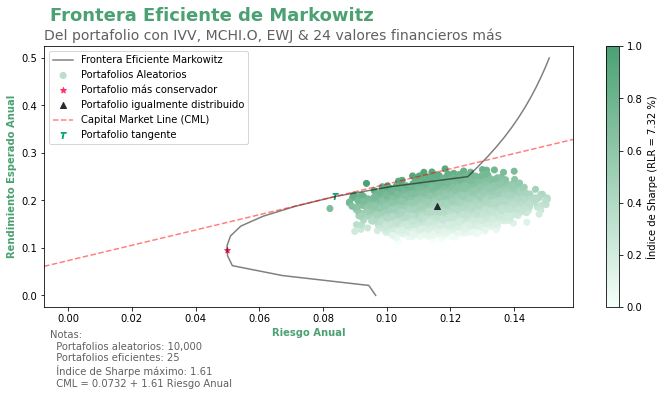

In [16]:
mm = Markowitz(portafolio_data, temporalidad="d", vlr_dict={"TIIE":rlr})
# mm.grafica_size = (15, 10)
mm.restricciones_base = [
    # Restrición de Renta Variable
    {'type':'eq', 'fun': lambda ponderaciones: mm.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_renta_variable, 0.6)},
    # Restricción internacional
    {'type':'eq', 'fun': lambda ponderaciones: mm.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_internacional, 0.2)},
    # Restricción de FIBRA
    {'type':'eq', 'fun': lambda ponderaciones: mm.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_fibras, 0.1)},
    # Restriccion economias indexadas 
    {'type':'eq', 'fun': lambda ponderaciones: mm.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_indexado_economia, mm.limite_indx_econ)},
    # Restriccion sectores indexados
    {'type':'eq', 'fun': lambda ponderaciones: mm.restricciones_ponderaciones_i_suman_x(ponderaciones, indices_indexado_sector, mm.limite_indx_sec)},
    # Restricción de todas las ponderaciones deben sumar 1
    {'type':'eq', 'fun': mm.restricciones_ponderaciones_sumanuno}
]
# Cambia el color de mapa de colores a Marxianos
mm.portal_cmap = cmap_marx

plot_, df_ = mm.portafolio_frontera_eficiente_resumen(anualizar=True, num_estimaciones=25, p_num=10000)

In [17]:
# Correlaciones
matrix = portafolio_data.corr().round(2)
# Matriz de correlacion sin 1
matrix_non_ones = matrix[matrix != 1]
corr_prom = matrix_non_ones.mean().mean()
corr_med = matrix_non_ones.median().median()
corr_min = matrix_non_ones.min().min()
corr_max = matrix_non_ones.max().max()

corr_tuples = [
    ("Mínimo", corr_min),
    ("Promedio", corr_prom),
    ("Mediana", corr_med),
    ("Máximo", corr_max)
]
# Tabla con resultados de correlaciones
pd.DataFrame(corr_tuples, columns=["Concepto", "Valor"]).round(2)

,Concepto,Valor
0,Mínimo,-0.11
1,Promedio,0.18
2,Mediana,0.18
3,Máximo,0.94


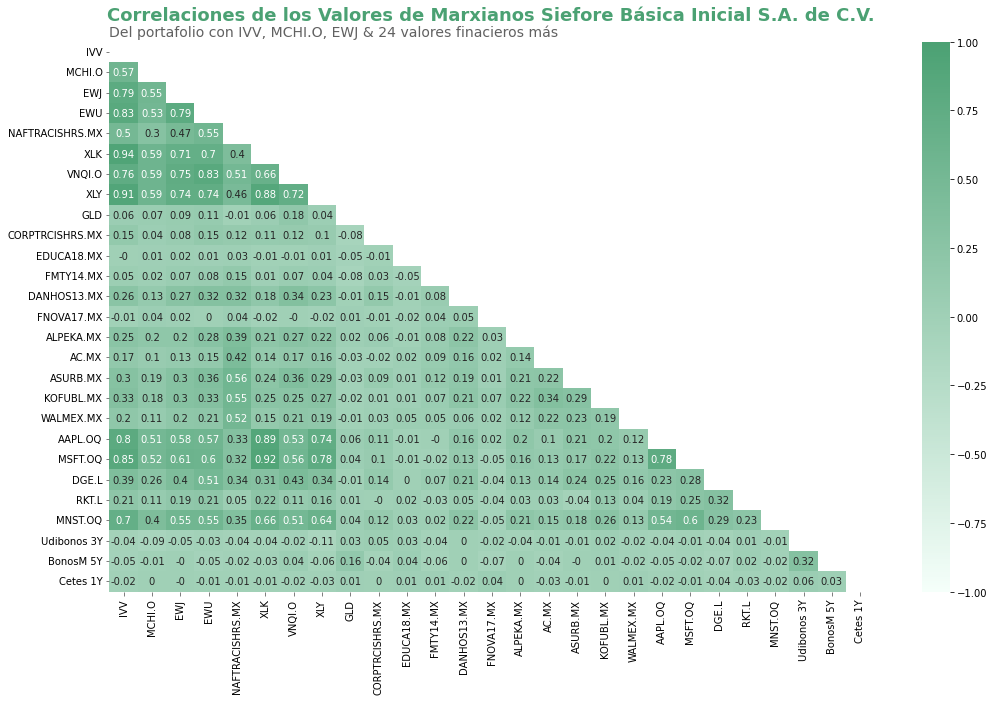

In [18]:
# Mascara para obtener solo la diagonal de correlaciones
plt.figure(figsize=(15,10))
mask_ = np.triu(np.ones_like(matrix, dtype=bool))
corr_ = sns.heatmap(matrix, annot=True, mask=mask_, cmap=cmap_marx, vmin=-1, vmax=1)
corr_sup = "Del portafolio con {} & {} valores finacieros más".format(", ".join(portafolio_data.columns[1:4]), len(portafolio_data.columns) - 4)
# Titulo
plt.suptitle(
    "Correlaciones de los Valores de Marxianos Siefore Básica Inicial S.A. de C.V.", fontweight="bold", size=mm.titulo_size,
     x=0.4575, y=0.97, ha="center", color=mm.titulo_color
    )
# Subtitulo
plt.title(
    corr_sup, size=mm.subtitulo_size, loc="left", x=0, color=mm.cuerpo_color
    )
plt.tight_layout()
plt.tick_params(color=mm.cuerpo_color, which="both")

In [19]:
df_.describe()

,Volatilidad Anual,Rendimiento Esperado Anual,Sharpe
count,27.000000,27.000000,27.000000
mean,0.104510,0.242025,1.374793
std,0.039046,0.150628,1.010629
min,0.049798,0.000000,-0.757944
25%,0.064271,0.114583,1.000000
50%,0.115831,0.229167,1.536189
75%,0.140432,0.364583,2.074465
max,0.151084,0.500000,2.824913


In [20]:
df_ef = df_.copy()
df_ef["Sharpe %"] = df_ef["Sharpe"].pct_change()
df_ef

,Volatilidad Anual,Rendimiento Esperado Anual,Ponderaciones,Sharpe,Sharpe %
pmc,0.049798,0.096481,"[3.243633896616893e-18, 1.580237066071817e-17,...",1.000000,NaN
pid,0.115831,0.188197,"[0.037037037037037035, 0.037037037037037035, 0...",1.000000,0.000000
eficiente0,0.096577,0.000000,"[8.998243847322388e-13, 0.07797464008612506, 4...",-0.757944,-1.757944
eficiente1,0.094418,0.020833,"[5.670275620102042e-19, 0.06182330947908777, 1...",-0.554624,-0.268252
eficiente2,0.067293,0.041667,"[3.3698877498476885e-17, 0.02401520176044352, ...",-0.468595,-0.155111
eficiente3,0.051570,0.062500,"[0.0, 7.174345864763627e-18, 0.0, 2.5364791113...",-0.207486,-0.557217
eficiente4,0.050068,0.083333,"[1.851692136089783e-18, 3.182325707181832e-17,...",0.202389,-1.975436
eficiente5,0.049887,0.104167,"[1.507889882667422e-17, 0.0, 4.24190499338723e...",0.620737,2.067041
eficiente6,0.050982,0.125000,"[5.5684924162735305e-18, 0.0, 2.04456739574320...",1.016051,0.636847
eficiente7,0.054226,0.145833,"[0.0, 4.92362249847686e-18, 0.0, 9.70975798980...",1.339453,0.318293


eficiente10 Rendimiento Anual: 20.83 | Volatilidad Anual: 8.40


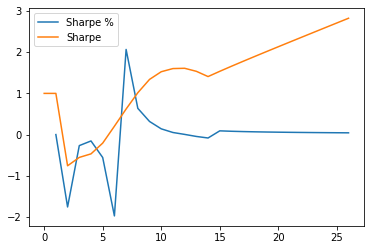

In [21]:
# Maximo msharpe
df_ef_msharpe = df_ef[df_ef["Sharpe %"] > 0]["Sharpe %"].idxmin()
df_ef_msharpe_ = df_ef.loc[df_ef_msharpe]
print(df_ef_msharpe, "Rendimiento Anual: {:.2f} | Volatilidad Anual: {:.2f}".format(
    df_ef_msharpe_["Rendimiento Esperado Anual"] * 100, df_ef_msharpe_["Volatilidad Anual"] * 100))
plt.plot(np.arange(len(df_ef.index)), df_ef["Sharpe %"], label="Sharpe %")
plt.plot(np.arange(len(df_ef.index)), df_ef["Sharpe"], label="Sharpe")
plt.legend()

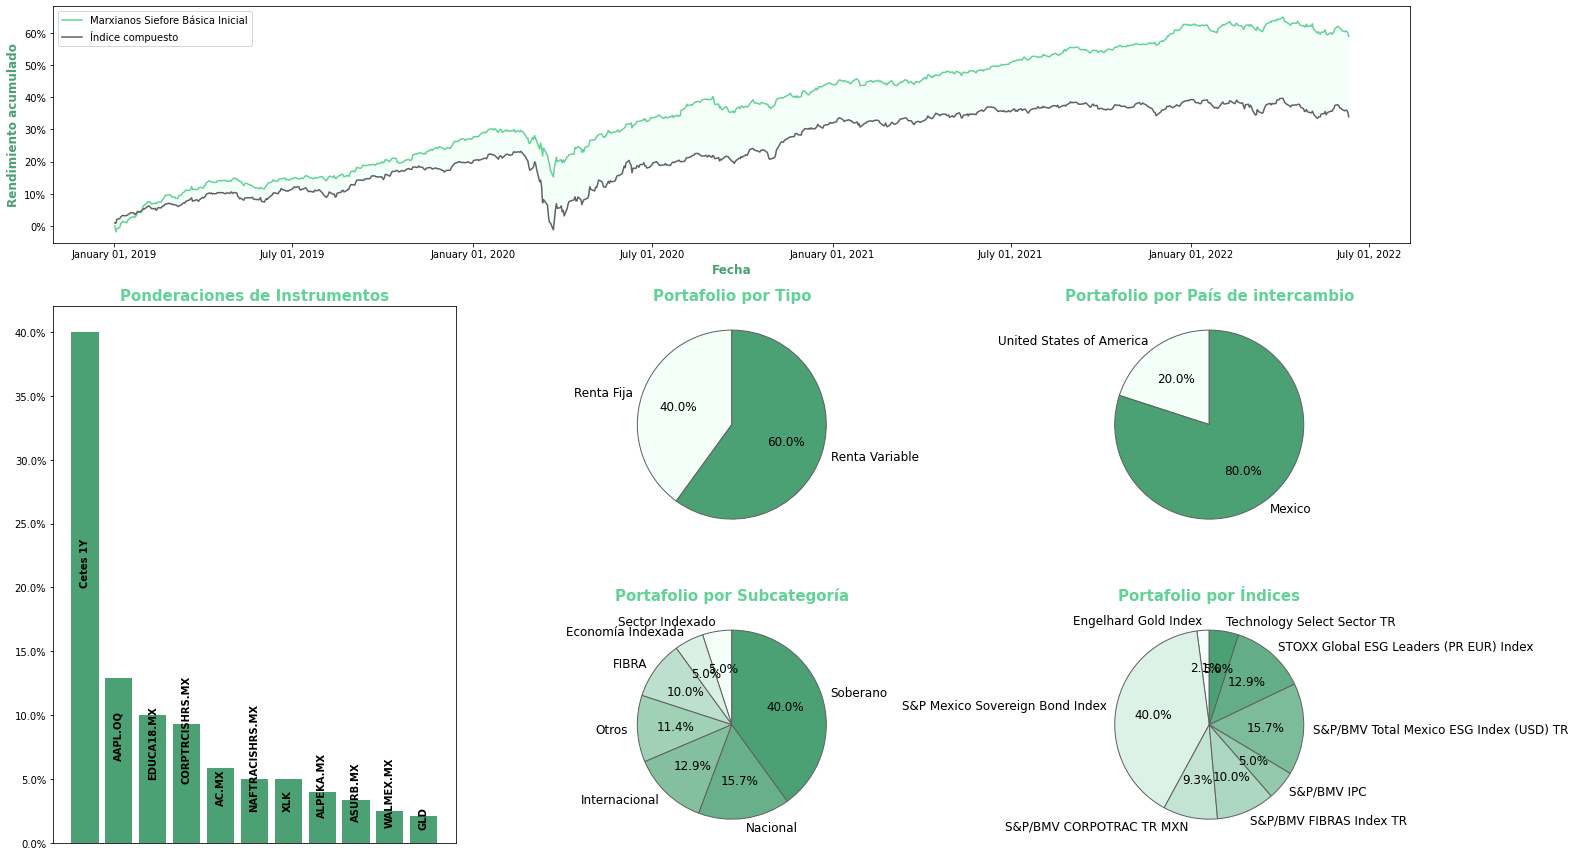

In [27]:
# Data
portafolio_info_p = portafolio_info.copy()
portafolio_info_p["Ponderaciones tangente"] = df_ef_msharpe_["Ponderaciones"]
size_title = 15
size_labels = 12
wedgeprops_ = {"edgecolor": color_cuerpo, "linewidth": 1, "antialiased": True}
textprops_ = {"fontsize": 12, "color": "k"}
# Ponderacion limite inferior para presentar en resultados
pond_inf = 0.001
vis = plt.figure(figsize=(22, 12))
grid = gridspec.GridSpec(3, 3, vis)

#sup_ = vis.suptitle("Composición del Portafolio de Marxianos Siefore Básica Inicial", fontweight="bold", fontsize=30)

# Main polots
sp_rendacum = plt.subplot(grid[0, :])
sp_tipo = plt.subplot(grid[1, 1])
sp_pais_intercambio = plt.subplot(grid[1, 2])
sp_subcategoria = plt.subplot(grid[2, 1])
sp_indice = plt.subplot(grid[2, 2])
sp_instrumentos = plt.subplot(grid[1:, 0])

subplot_titles = ["Tipo", "País de intercambio", "Subcategoría"]
subplot_sp = [sp_tipo, sp_pais_intercambio, sp_subcategoria]


# Rendimientos acumulados de portafolio tangente
portafolio_data_p = portafolio_data.copy()
# Multiplica los rendimientos por las ponderaciones tangentes
portafolio_data_p["Portafolio Rendimiento ponderado"] = portafolio_data_p.apply(
    lambda rendimientos: (np.array(rendimientos[1:]) * np.array(portafolio_info_p["Ponderaciones tangente"])).sum(), axis=1)
# Solo selecciona la fecha y rendimientos ponderados
rendimientos_p = portafolio_data_p[["Date", "Portafolio Rendimiento ponderado"]].copy()
# Crea una columna con los rendimientos ponderados acumulados
rendimientos_p["Portafolio Rendimiento acumulado"] = rendimientos_p["Portafolio Rendimiento ponderado"].cumsum()
# Cambia el tipo de dato de la fecha a datetime para su visualización
rendimientos_p = rendimientos_p.astype({"Date":"datetime64"})
# Formato de Mes completo día, Año
myFmt = mdates.DateFormatter("%B %d, %Y")


# Editar
# Rendimientos acumulados del indice
indx_ = portafolio_info_p.pivot_table(index=["Nombre Benchmark", "Benchmark RIC"], values="Ponderaciones tangente", aggfunc=np.sum).reset_index()
# Indices con ponderaciones mayor a la ponderacion inferior permitida
indx_z = indx_[indx_["Ponderaciones tangente"] > pond_inf]
indx_data = indices_data[["Date", * indx_["Benchmark RIC"]]].astype({"Date":"datetime64"})
#indx_data = indx_data.loc[rendimientos_p["Date"]]
indx_data["Benchmark Rendimiento ponderado"] = indx_data.apply(lambda indices_rendimientos: (np.array(indices_rendimientos[1:]) * np.array(indx_["Ponderaciones tangente"])).sum(), axis=1)
indx_data["Benchmark Rendimiento acumulado"] = indx_data["Benchmark Rendimiento ponderado"].cumsum()


benchmark_data = indx_data[["Date", "Benchmark Rendimiento acumulado"]].merge(rendimientos_p[["Date", "Portafolio Rendimiento acumulado"]], on="Date", how="inner")


sp_rendacum.plot(benchmark_data["Date"], benchmark_data["Portafolio Rendimiento acumulado"] * 100, "-", color=color_subtitulo, label="Marxianos Siefore Básica Inicial")
sp_rendacum.plot(benchmark_data["Date"], benchmark_data["Benchmark Rendimiento acumulado"] * 100, "-", color=color_cuerpo, label="Índice compuesto")
sp_rendacum.fill_between(
    benchmark_data["Date"], benchmark_data["Portafolio Rendimiento acumulado"] * 100, benchmark_data["Benchmark Rendimiento acumulado"] * 100,
    color=color_fondo)
# Pone formato de fecha
sp_rendacum.xaxis.set_major_formatter(myFmt)
# Pone formato a porcentaje
sp_rendacum.yaxis.set_major_formatter(mtick.PercentFormatter())
sp_rendacum.set_xlabel("Fecha", weight="bold", color=color_titulo, size=size_labels)
sp_rendacum.set_ylabel("Rendimiento acumulado", weight="bold", color=color_titulo, size=size_labels)
sp_rendacum.legend()


for sp, title in zip(subplot_sp, subplot_titles):
    data = portafolio_info_p.pivot_table(index=title, values="Ponderaciones tangente", aggfunc=np.sum).reset_index().sort_values(by="Ponderaciones tangente", ascending=True)
    data = data[data["Ponderaciones tangente"] > pond_inf]
    n_rows = len(data.index)
    cs_ = cmap_marx(np.linspace(0., 1., n_rows))
    explode_ = (0.01, ) * n_rows
    sp.pie(
        data["Ponderaciones tangente"], labels=data[title], autopct="%1.1f%%", colors=cs_, wedgeprops=wedgeprops_,
        textprops=textprops_, startangle=90)
    sp.set_title("Portafolio por {}".format(title), weight="bold", size=size_title, color=color_subtitulo)

# Por Acción
# Portafolio instrumentos sorted
p_info_is = portafolio_info_p.sort_values(by="Ponderaciones tangente", ascending=False)[["Instrumento", "Ponderaciones tangente"]]
p_info_is_z = p_info_is[p_info_is["Ponderaciones tangente"] > pond_inf]
sp_instrumentos.bar(p_info_is_z["Instrumento"], p_info_is_z["Ponderaciones tangente"] * 100, color=color_titulo)
sp_instrumentos.set_title("Ponderaciones de Instrumentos", weight="bold", size=size_title, color=color_subtitulo)


for i, ins in enumerate(p_info_is_z["Instrumento"]):
    sp_instrumentos.text(
        i, p_info_is_z["Ponderaciones tangente"].iloc[i] * 100 / 2, s=ins, ha="center", rotation=90, va="bottom",
        weight="bold")

# Apaga el xaxis para que no muestre las etiquetas 
sp_instrumentos.axes.xaxis.set_visible(False)
# Pone formato a porcentaje
sp_instrumentos.yaxis.set_major_formatter(mtick.PercentFormatter())

cs_ = cmap_marx(np.linspace(0., 1., len(indx_z.index)))
sp_indice.pie(
    indx_z["Ponderaciones tangente"], labels=indx_z["Nombre Benchmark"], autopct="%1.1f%%", colors=cs_, wedgeprops=wedgeprops_,
    startangle=90, textprops=textprops_)
sp_indice.set_title("Portafolio por Índices", weight="bold", size=size_title, color=color_subtitulo)

vis.tight_layout()

In [28]:
p_info_is_z

,Instrumento,Ponderaciones tangente
26,Cetes 1Y,0.400000
19,AAPL.OQ,0.129113
10,EDUCA18.MX,0.100000
9,CORPTRCISHRS.MX,0.093093
15,AC.MX,0.058827
4,NAFTRACISHRS.MX,0.050000
5,XLK,0.050000
14,ALPEKA.MX,0.039802
16,ASURB.MX,0.033163
18,WALMEX.MX,0.025115


In [29]:
var_ = mm.valores_estadisticas(anualizar=True).reset_index()
var_ = var_.rename(columns={"index":"Instrumento"})[["Instrumento", "Rendimiento Esperado Anual", "Desv. Std. Anual"]]

portafolio_info_pp = portafolio_info_p.merge(var_, on="Instrumento")
portafolio_info_pp

probabilidad = 0.99
F = norm.ppf(probabilidad)
S = 1000
t = 1/365

# Caclula VaR por instrumento
portafolio_info_pp["VaR"] = portafolio_info_pp.apply(
    lambda instrumento: F * instrumento["Ponderaciones tangente"] * S * instrumento["Desv. Std. Anual"] * np.sqrt(t), axis=1)

# Calcula VaR parametrico
var_n = np.sqrt(np.dot(np.dot(portafolio_info_pp["VaR"], matrix), portafolio_info_pp["VaR"]))
print("VaR @ {:.2f}% : {:.2f}% ".format(probabilidad * 100, var_n / S * 100))

portafolio_info_pp

VaR @ 99.00% : 1.02% 


,Instrumento,Tipo,Categoría,Subcategoría,Nombre,País de intercambio,Nombre Benchmark,Benchmark RIC,Ponderaciones tangente,Rendimiento Esperado Anual,Desv. Std. Anual,VaR
0,IVV,Renta Variable,ETF,Economía Indexada,iShares Core S&P 500 ETF,United States of America,S&P 500 TR,.SPXTR,0.000000e+00,0.204622,0.225735,0.000000e+00
1,MCHI.O,Renta Variable,ETF,Economía Indexada,iShares MSCI China ETF,United States of America,MSCI China NR USD,.dMICN00000NUS,3.263974e-17,0.065888,0.299691,1.191102e-15
2,EWJ,Renta Variable,ETF,Economía Indexada,iShares MSCI Japan ETF,United States of America,MSCI Japan NR USD,.dMIJP00000NUS,0.000000e+00,0.079661,0.184863,0.000000e+00
3,EWU,Renta Variable,ETF,Economía Indexada,iShares MSCI United Kingdom ETF,United States of America,MSCI United Kingdom NR USD,.dMIGB00000NUS,0.000000e+00,0.099329,0.233569,0.000000e+00
4,NAFTRACISHRS.MX,Renta Variable,ETF,Economía Indexada,iShares NAFTRAC,Mexico,S&P/BMV IPC,.MXX,5.000000e-02,0.088589,0.177426,1.080226e+00
5,XLK,Renta Variable,ETF,Sector Indexado,Technology Select Sector SPDR Fund,United States of America,Technology Select Sector TR,.IXTTR,5.000000e-02,0.327963,0.284171,1.730125e+00
6,VNQI.O,Renta Variable,ETF,Sector Indexado,Vanguard Global ex-US Real Estate Index Fd;ETF,United States of America,S&P Global Ex-U.S. Property TR,.SPBMGUU,5.339541e-17,0.040751,0.185206,1.204167e-15
7,XLY,Renta Variable,ETF,Sector Indexado,Consumer Discretionary Select Sector SPDR Fund,United States of America,Consumer Discretionary Select Sector TR,.IXYTR,3.740658e-18,0.180921,0.255011,1.161541e-16
8,GLD,Renta Variable,ETF,Otros,SPDR Gold Shares,United States of America,Engelhard Gold Index,.GLDD,2.088714e-02,0.134974,0.151012,3.840768e-01
9,CORPTRCISHRS.MX,Renta Variable,ETF,Otros,iShares Mexico Corporate Bond TRAC,Mexico,S&P/BMV CORPOTRAC TR MXN,.SPVCORT,9.309297e-02,0.098185,0.198118,2.245794e+00


In [30]:
# Instrumentos finales
portafolio_info_ppz = portafolio_info_pp.set_index("Instrumento")
portafolio_info_ppz = portafolio_info_ppz.loc[p_info_is_z["Instrumento"]]
portafolio_info_ppz.to_csv("datasets/Marxianos_portfolio_final_220610.csv")
portafolio_info_ppz


,Tipo,Categoría,Subcategoría,Nombre,País de intercambio,Nombre Benchmark,Benchmark RIC,Ponderaciones tangente,Rendimiento Esperado Anual,Desv. Std. Anual,VaR
Instrumento,,,,,,,,,,,
Cetes 1Y,Renta Fija,Bono,Soberano,Certificados de la Tesorería de la Federación,Mexico,S&P Mexico Sovereign Bond Index,.SPVSOVG,0.400000,-0.003892,0.029579,1.440680
AAPL.OQ,Renta Variable,Acción,Internacional,Apple Inc,United States of America,STOXX Global ESG Leaders (PR EUR) Index,.SXWESGP,0.129113,0.549844,0.340585,5.354559
EDUCA18.MX,Renta Variable,Acción,FIBRA,Grupo Nagoin SA de CV,Mexico,S&P/BMV FIBRAS Index TR,.FR,0.100000,0.806622,0.240275,2.925753
CORPTRCISHRS.MX,Renta Variable,ETF,Otros,iShares Mexico Corporate Bond TRAC,Mexico,S&P/BMV CORPOTRAC TR MXN,.SPVCORT,0.093093,0.098185,0.198118,2.245794
AC.MX,Renta Variable,Acción,Nacional,Arca Continental SAB de CV,Mexico,S&P/BMV Total Mexico ESG Index (USD) TR,.UR0000,0.058827,0.114086,0.219195,1.570126
NAFTRACISHRS.MX,Renta Variable,ETF,Economía Indexada,iShares NAFTRAC,Mexico,S&P/BMV IPC,.MXX,0.050000,0.088589,0.177426,1.080226
XLK,Renta Variable,ETF,Sector Indexado,Technology Select Sector SPDR Fund,United States of America,Technology Select Sector TR,.IXTTR,0.050000,0.327963,0.284171,1.730125
ALPEKA.MX,Renta Variable,Acción,Nacional,Alpek SAB de CV,Mexico,S&P/BMV Total Mexico ESG Index (USD) TR,.UR0000,0.039802,0.197988,0.319900,1.550398
ASURB.MX,Renta Variable,Acción,Nacional,Grupo Aeroportuario del Sureste SAB de CV,Mexico,S&P/BMV Total Mexico ESG Index (USD) TR,.UR0000,0.033163,0.226419,0.331340,1.338007


In [32]:
# Guarda los datos de importancia en un solo excel
ExcelWriter = pd.ExcelWriter("Marxianos_Datos.xlsx", engine="xlsxwriter")

dataframes_importantes = [
    ("Todos_Activos_Info", portafolio_info),
    ("Todos_Activos_Rend", portafolio_data),
    ("Todos_Activos_Stats", portafolio_data.describe().T.reset_index()),
    ("Indices_Rend", indices_data),
    ("Portafolio_Final", portafolio_info_ppz)
]

for nombre, dataframe in dataframes_importantes:
    dataframe.to_excel(ExcelWriter, sheet_name=nombre, index=False)

# Guarda el Excel
ExcelWriter.save()